In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import keras.api._v2.keras as keras
from keras import mixed_precision
import numpy as np
import matplotlib.pyplot as plt

2023-07-06 15:52:32.757736: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 15:52:32.862927: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
gpus = tf.config.list_physical_devices("GPU")
print(gpus)

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# mirrored_strategy = tf.distribute.MirroredStrategy()

# mixed_precision.set_global_policy('mixed_float16')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [3]:
path = "Ecmnist/fgbg_cmnist_cpr0.5-0.5/"
mnist_train = tf.convert_to_tensor(np.load(path + "colored_mnist_init_train.npy") * 255)
mnist_test = tf.convert_to_tensor(np.load(path + "colored_mnist_init_test.npy") * 255)
mnist_train_target = tf.convert_to_tensor(
    np.load(path + "colored_mnist_target_train.npy")
)
mnist_test_target = tf.convert_to_tensor(
    np.load(path + "colored_mnist_target_test.npy")
)

mnist_train = tf.transpose(mnist_train, [0, 2, 3, 1])
mnist_test = tf.transpose(mnist_test, [0, 2, 3, 1])

print(mnist_train.shape, mnist_test.shape)
print(mnist_train_target.shape, mnist_test_target.shape)

train_data = tf.data.Dataset.from_tensor_slices(((mnist_train, mnist_train_target),))

batch_size = 128
train_data = train_data.shuffle(10000).batch(batch_size)

2023-07-06 15:52:35.207849: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 15:52:35.419200: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38362 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:d8:00.0, compute capability: 8.0


(60000, 28, 28, 3) (10000, 28, 28, 3)
(60000, 7) (10000, 7)


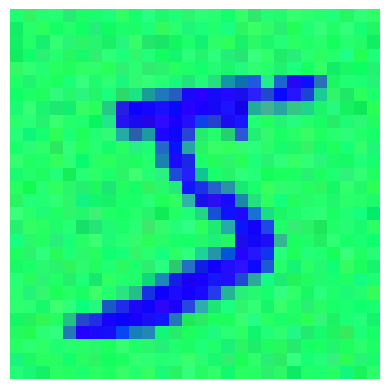

In [4]:
plt.figure(1)
plt.imshow(mnist_train[0, :, :, :] / 255)
plt.axis("off")
plt.show()

In [5]:
image_shape = (28, 28, 3)
label_shape = (7,)
dist = tfp.distributions.PixelCNN(
    image_shape=image_shape,
    conditional_shape=label_shape,
    num_resnet=1,
    num_hierarchies=2,
    num_filters=64,
    num_logistic_mix=10,
    dropout_p=0.3,
)

image_input = keras.layers.Input(shape=image_shape)
label_input = keras.layers.Input(shape=label_shape)

log_prob = dist.log_prob(image_input, conditional_input=label_input)

class_cond_model = keras.Model(inputs=[image_input, label_input], outputs=log_prob)
class_cond_model.add_loss(-tf.reduce_mean(log_prob))

class_cond_model.compile(optimizer=keras.optimizers.Adam(), metrics=[])

print(class_cond_model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 7)]          0           []                               
                                                                                                  
 tf.convert_to_tensor (TFOpLamb  (None, 28, 28, 3)   0           ['input_3[0][0]']                
 da)                                                                                              
                                                                                                  
 tf.convert_to_tensor_2 (TFOpLa  (None, 7)           0           ['input_4[0][0]']          

In [6]:
class_cond_model.fit(train_data, epochs=20)

Epoch 1/20


2023-07-06 15:52:47.598120: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-06 15:52:47.639384: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8800


469/469 [==============================] - 42s 70ms/step - loss: 8476.1650
Epoch 2/20
469/469 [==============================] - 31s 67ms/step - loss: 7890.7227
Epoch 3/20
469/469 [==============================] - 31s 67ms/step - loss: 7805.9741
Epoch 4/20
469/469 [==============================] - 31s 67ms/step - loss: 7759.9380
Epoch 5/20
469/469 [==============================] - 31s 67ms/step - loss: 7900.2012
Epoch 6/20
469/469 [==============================] - 31s 66ms/step - loss: 7864.9111
Epoch 7/20
469/469 [==============================] - 31s 67ms/step - loss: 7777.5654
Epoch 8/20
469/469 [==============================] - 31s 67ms/step - loss: 7747.1460
Epoch 9/20
469/469 [==============================] - 31s 67ms/step - loss: 7723.7617
Epoch 10/20
469/469 [==============================] - 31s 67ms/step - loss: 7712.9722
Epoch 11/20
469/469 [==============================] - 31s 67ms/step - loss: 7732.3677
Epoch 12/20
469/469 [==============================] - 31s 67ms

In [7]:
num_images = 5
generated_images = dist.sample(
    num_images, conditional_input=mnist_train_target[:num_images, :]
)

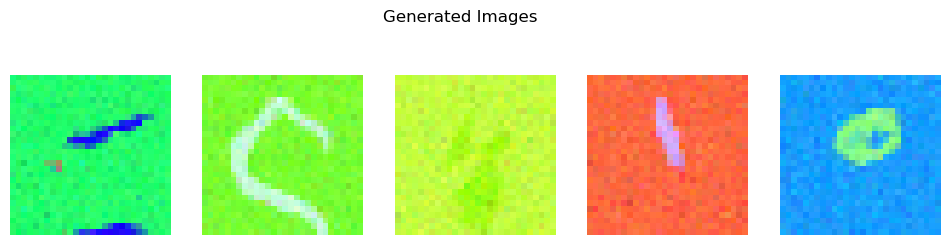

In [8]:
plt.figure(figsize=(12, 3))
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(generated_images[i, :, :, :] / 255)
    plt.axis("off")

plt.suptitle("Generated Images")
plt.show()

In [9]:
generated_images = dist.sample(
    num_images, conditional_input=mnist_test_target[:num_images, :]
)

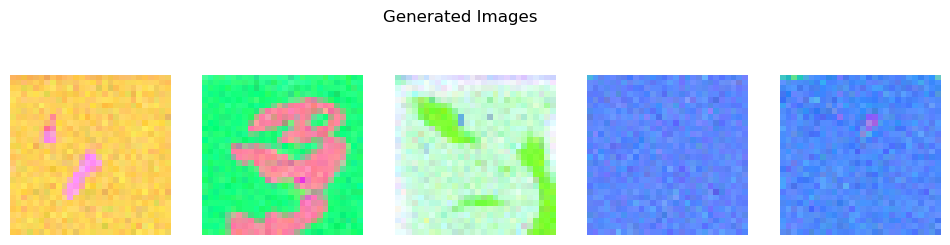

In [10]:
plt.figure(figsize=(12, 3))
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(generated_images[i, :, :, :] / 255)
    plt.axis("off")

plt.suptitle("Generated Images")
plt.show()